# Parte 2 – Clusterização e Classificação (2,5)

 Implementar em contêiner na plataforma o modelo de Clusterização e Classificação desenvolvido na disciplina de Machine Learning.

 1. Criar Clusters de clientes que pedem empréstimo, de acordo com o visto na disciplina de Machine Learning (0,25)

  dica: não utilize a coluna target no processo

 2. Analisar cada cluster atribuindo a ele uma label de “persona”, de acordo com as características identificadas nos centróides (caso use k-means) ou majoritariamente nos grupos (0,25)

 3. Identificar a propensão à fraude média de cada grupo (0,25)

 4. Criar API que retorne i) o grupo a que o cliente pertence; ii) o label de persona; iii) a propensão à fraude média do grupo (0,75)

 5. Encapsular o modelo em um contêiner (1,00).– O Contêiner deve apenas receber os parâmetros de entrada e retornar a propensão da inadimplência

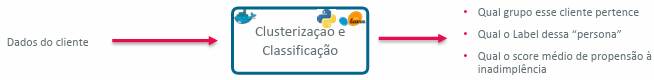

Nota: A API só precisa retornar os dados descritos no requisito 4. A criação de um modelo "fake" que retorna aleatoriamente a saída desejada desabona apenas o 0,75 ponto dos requisitos 1, 2 e 3.

## 1- Criar Clusters de clientes que pedem empréstimo

### Instalações

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.colab import auth

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

### Conexão com o Big Query

In [2]:
auth.authenticate_user()

In [3]:
# Aqui devo fazer a conexão em meu próprio projeto (utilizei o rm347975)
project_id = input("Por favor, informe o project_id: ")

Por favor, informe o project_id: rm347975


In [4]:
clientbq = bigquery.Client(project=project_id)

query_sql = f"""
  SELECT *
  FROM `emf-teacher.trabalho_loans.loan_default`
"""

query_job = clientbq.query(query_sql)  # Make an API request.
loans_data = query_job.to_dataframe()

In [5]:
loans_data.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.0,148670.0,148670.0,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.0,133572.000000,148670.0,124549.000000
mean,99224.5,2019.0,331117.743997,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,183909.310127,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.0,2019.0,16500.0,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.0,0.967478,0.0,5.000000
25%,62057.25,2019.0,196500.0,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.0,60.474860,0.0,31.000000
50%,99224.5,2019.0,296500.0,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.0,75.135870,0.0,39.000000
75%,136391.75,2019.0,436500.0,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.0,86.184211,0.0,45.000000
max,173559.0,2019.0,3576500.0,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.0,7831.250000,1.0,61.000000


In [6]:
loans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  Int64  
 1   year                       148670 non-null  Int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  Int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

### Tratativa dos campos

In [7]:
# Verificar quais colunas possuem valores nulos
print(loans_data.columns[loans_data.isnull().any()])

Index(['loan_limit', 'approv_in_adv', 'loan_purpose', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'property_value', 'income', 'age', 'LTV', 'dtir1'],
      dtype='object')


In [8]:
# Remover linhas onde as colunas categóricas são nulas
loans_data = loans_data.dropna(subset=['loan_limit'])
loans_data = loans_data.dropna(subset=['approv_in_adv'])
loans_data = loans_data.dropna(subset=['loan_purpose'])
loans_data = loans_data.dropna(subset=['Neg_ammortization'])
loans_data = loans_data.dropna(subset=['age'])

In [9]:
# Substituir os valores nulos pela mediana
loans_data.loc[:, 'rate_of_interest'] = loans_data['rate_of_interest'].fillna(loans_data['rate_of_interest'].median())
loans_data.loc[:, 'Interest_rate_spread'] = loans_data['Interest_rate_spread'].fillna(loans_data['Interest_rate_spread'].median())
loans_data.loc[:, 'Upfront_charges'] = loans_data['Upfront_charges'].fillna(loans_data['Upfront_charges'].median())
loans_data.loc[:, 'term'] = loans_data['term'].fillna(loans_data['term'].median())
loans_data.loc[:, 'property_value'] = loans_data['property_value'].fillna(loans_data['property_value'].median())
loans_data.loc[:, 'income'] = loans_data['income'].fillna(loans_data['income'].median())
loans_data.loc[:, 'LTV'] = loans_data['LTV'].fillna(loans_data['LTV'].median())
loans_data.loc[:, 'dtir1'] = loans_data['dtir1'].fillna(loans_data['dtir1'].median())

In [10]:
# Ajustanto o tipo da coluna Status
loans_data['Status'] = loans_data['Status'].astype('category')

In [11]:
# Conferindo se sobraram colunas com valores nulos
print(loans_data.columns[loans_data.isnull().any()])

Index([], dtype='object')


In [23]:
nomes_colunas  =   ["loan_limit",               "approv_in_adv",        "loan_type",
                    "loan_purpose",             "Credit_Worthiness",     "Interest_rate_spread",
                    "Neg_ammortization",        "interest_only",         "lump_sum_payment",
                    "occupancy_type",           "total_units",           "credit_type",
                    "co_applicant_credit_type", "age",                   "submission_of_application",
                    "Region",                   "Status"]
loans_data_selec = loans_data.loc[:, nomes_colunas]

loans_data_selec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143983 entries, 0 to 148669
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   loan_limit                 143983 non-null  object  
 1   approv_in_adv              143983 non-null  object  
 2   loan_type                  143983 non-null  object  
 3   loan_purpose               143983 non-null  object  
 4   Credit_Worthiness          143983 non-null  object  
 5   Interest_rate_spread       143983 non-null  float64 
 6   Neg_ammortization          143983 non-null  object  
 7   interest_only              143983 non-null  object  
 8   lump_sum_payment           143983 non-null  object  
 9   occupancy_type             143983 non-null  object  
 10  total_units                143983 non-null  object  
 11  credit_type                143983 non-null  object  
 12  co_applicant_credit_type   143983 non-null  object  
 13  age           

In [24]:
# Criando uma nova base de dados sem a coluna target
loans_data_classif = loans_data_selec.drop(columns=['Status'])

In [25]:
# Usando o método one-hot-encode para tratar as variáveis categóricas
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_limit'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['approv_in_adv'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_purpose'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Credit_Worthiness'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Neg_ammortization'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['interest_only'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['lump_sum_payment'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['occupancy_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['credit_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['total_units'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['co_applicant_credit_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['age'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['submission_of_application'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Region'])

In [26]:
loans_data_classif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143983 entries, 0 to 148669
Data columns (total 46 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Interest_rate_spread                143983 non-null  float64
 1   loan_limit_cf                       143983 non-null  uint8  
 2   loan_limit_ncf                      143983 non-null  uint8  
 3   approv_in_adv_nopre                 143983 non-null  uint8  
 4   approv_in_adv_pre                   143983 non-null  uint8  
 5   loan_type_type1                     143983 non-null  uint8  
 6   loan_type_type2                     143983 non-null  uint8  
 7   loan_type_type3                     143983 non-null  uint8  
 8   loan_purpose_p1                     143983 non-null  uint8  
 9   loan_purpose_p2                     143983 non-null  uint8  
 10  loan_purpose_p3                     143983 non-null  uint8  
 11  loan_purpose_p4           

## 2- Analisar cada cluster atribuindo a ele uma label de “persona”, de acordo com as características identificadas nos centróides

### Aplicando K-Means para separar em Clusters

In [27]:
std = StandardScaler()
std.fit(loans_data_classif)

StandardScaler()

In [28]:
normalized_data = std.transform(loans_data_classif)
normalized_data

array([[-0.08696089,  0.26964202, -0.26964202, ..., -0.09194456,
        -0.2490328 , -0.86890238],
       [-0.08696089,  0.26964202, -0.26964202, ..., -0.09194456,
        -0.2490328 , -0.86890238],
       [-0.08696089,  0.26964202, -0.26964202, ..., -0.09194456,
        -0.2490328 , -0.86890238],
       ...,
       [-0.08696089,  0.26964202, -0.26964202, ..., -0.09194456,
        -0.2490328 ,  1.15087727],
       [-1.14812017,  0.26964202, -0.26964202, ..., -0.09194456,
        -0.2490328 ,  1.15087727],
       [-0.08696089, -3.7086208 ,  3.7086208 , ..., -0.09194456,
        -0.2490328 ,  1.15087727]])

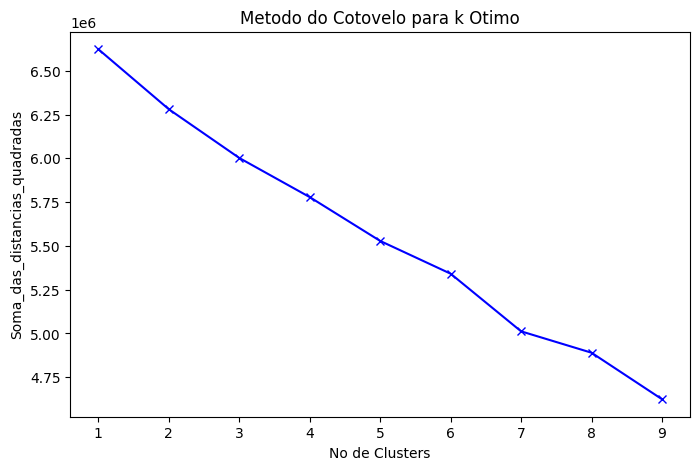

In [29]:
plt.figure(figsize=(8,5))

K = range(1,10)

Sum_of_squared_distances = []

for k in K:
  # O n_init representa por quantas vezes o algorítmo vai rodar, tentando adequar a melhor posição dos centróides
  km = KMeans(n_clusters=k, n_init=10)
  km = km.fit(normalized_data)

  # O inertia_ é a soma quadrática das distâncias
  Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('No de Clusters')
plt.ylabel('Soma_das_distancias_quadradas')
plt.title('Metodo do Cotovelo para k Otimo')
plt.show()

*Consideraremos, de acordo com a regra do cotovelo, o K = 5 (quantidade de grupos)*

In [30]:
km = KMeans(n_clusters=5, n_init=10)
km = km.fit(normalized_data)

In [31]:
# Aplicando as personas via kmeans, ajustando a coluna para tipo categórico
loans_data_classif['persona'] = km.labels_
loans_data_classif['persona'] = loans_data_classif['persona'].astype('category')

# Aplicando o mesmo na tabela original
loans_data['persona'] = km.labels_
loans_data['persona'] = loans_data['persona'].astype('category')

In [32]:
# Obter valores únicos da coluna 'persona'
valores_possiveis = sorted(loans_data_classif['persona'].unique())

# Iterar sobre os valores possíveis e contar o número de ocorrências
for valor in valores_possiveis:
    count = loans_data_classif['persona'].value_counts().get(valor, 0)
    print(f"Registros com persona = {valor}: {count}")

Registros com persona = 0: 9437
Registros com persona = 1: 74172
Registros com persona = 2: 7258
Registros com persona = 3: 40659
Registros com persona = 4: 12457


### Aplicando PCA para reduzir a dimensionalidade para 2 componentes

In [33]:
# Selecionar apenas as colunas de features
features = loans_data_classif.drop(columns=['persona'])

In [34]:
# # Normalizar os dados usando StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(loans_data_classif)

In [35]:
# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

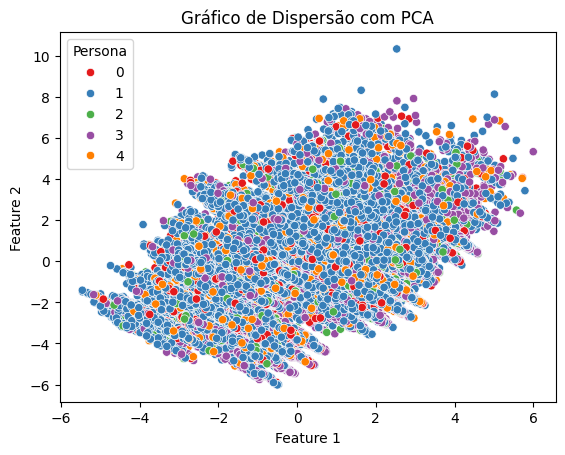

In [36]:
# Criar um DataFrame com os componentes principais
principal_df = pd.DataFrame(data=principal_components, columns=['Feature 1', 'Feature 2'])

# Adicionar a coluna 'persona' ao DataFrame principal_df
principal_df['persona'] = loans_data['persona']

# Plotar o gráfico de dispersão usando Seaborn
sns.scatterplot(data=principal_df, x='Feature 1', y='Feature 2', hue='persona', palette='Set1')
plt.title('Gráfico de Dispersão com PCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Persona')
plt.show()

## 3- Identificar a propensão à fraude média de cada grupo

In [37]:
# Lista com os nomes das colunas desejadas
# nomes_features = ["loan_limit", "Gender", "approv_in_adv", "loan_type", "loan_purpose", "Credit_Worthiness",
#                   "open_credit", "business_or_commercial", "loan_amount", "rate_of_interest", "Interest_rate_spread",
#                   "Upfront_charges", "term", "Neg_ammortization", "interest_only", "lump_sum_payment", "property_value",
#                   "construction_type", "occupancy_type", "total_units", "income", "credit_type", "Credit_Score",
#                   "co_applicant_credit_type", "age", "submission_of_application", "LTV", "Region", "dtir1"]
nomes_features =   ["loan_limit",               "approv_in_adv",        "loan_type",
                    "loan_purpose",             "Credit_Worthiness",     "Interest_rate_spread",
                    "Neg_ammortization",        "interest_only",         "lump_sum_payment",
                    "occupancy_type",           "total_units",           "credit_type",
                    "co_applicant_credit_type", "age",                   "submission_of_application", "Region"]

# Selecionar as colunas desejadas para uma linha específica
loans_data_validar = loans_data.loc[:, nomes_features]

In [38]:
loans_data_validar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143983 entries, 0 to 148669
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 143983 non-null  object 
 1   approv_in_adv              143983 non-null  object 
 2   loan_type                  143983 non-null  object 
 3   loan_purpose               143983 non-null  object 
 4   Credit_Worthiness          143983 non-null  object 
 5   Interest_rate_spread       143983 non-null  float64
 6   Neg_ammortization          143983 non-null  object 
 7   interest_only              143983 non-null  object 
 8   lump_sum_payment           143983 non-null  object 
 9   occupancy_type             143983 non-null  object 
 10  total_units                143983 non-null  object 
 11  credit_type                143983 non-null  object 
 12  co_applicant_credit_type   143983 non-null  object 
 13  age                        14

In [39]:
!pip install rpy2
import rpy2.robjects as robjects

In [63]:
# Carregar o modelo R usando load()
robjects.r['load']("/content/modelo_rlog.RData")

# Verificar o tipo do objeto modelofinal_rlog
print(type(robjects.globalenv['modelofinal_rlog']))

<class 'rpy2.robjects.vectors.ListVector'>


### Teste - Com 1 linha preenchida manualmente

In [ ]:
# # Preparar os dados
# loan_data_t1 = {
#     'loan_limit': 'cf',
#     'Gender': 'Male',
#     'approv_in_adv': 'nopre',
#     'loan_type': 'type3',
#     'loan_purpose': 'p4',
#     'Credit_Worthiness': 'l1',
#     'open_credit': 'nopc',
#     'business_or_commercial': 'nob/c',
#     'loan_amount': 296500,
#     'rate_of_interest': 3.99,
#     'Interest_rate_spread': 0.39,
#     'Upfront_charges': 2596,
#     'term': 360,
#     'Neg_ammortization': 'not_neg',
#     'interest_only': 'not_int',
#     'lump_sum_payment': 'lpsm',
#     'property_value': 418000,
#     'construction_type': 'sb',
#     'occupancy_type': 'ir',
#     'total_units': '1U',
#     'income': 6957,
#     'credit_type': 'CRIF',
#     'Credit_Score': 699,
#     'co_applicant_credit_type': 'EXP',
#     'age': '25-34',
#     'submission_of_application': 'to_inst',
#     'LTV': 72.7,
#     'Region': 'North',
#     'dtir1': 39
# }

In [64]:
# Preparar os dados
loan_data_t1 = {
            "loan_limit": "cf",
            "approv_in_adv": "nopre",
            "loan_type": "type3",
            "loan_purpose": "p4",
            "Credit_Worthiness": "l1",
            "Interest_rate_spread": 0.39,
            "Neg_ammortization": "not_neg",
            "interest_only": "not_int",
            "lump_sum_payment": "lpsm",
            "occupancy_type": "ir",
            "total_units": "1U",
            "credit_type": "CRIF",
            "co_applicant_credit_type": "EXP",
            "age": "25-34",
            "submission_of_application": "to_inst",
            "Region": "North"
}

In [65]:
# Converter o dicionário Python em um DataFrame R
df_loan_data_t1 = robjects.DataFrame({key: robjects.FloatVector([value]) if isinstance(value, float) else robjects.IntVector([value]) if isinstance(value, int) else robjects.StrVector([value]) for key, value in loan_data_t1.items()})
print(df_loan_data_t1)

  loan_limit approv_in_adv loan_type loan_purpose Credit_Worthiness
1         cf         nopre     type3           p4                l1
  Interest_rate_spread Neg_ammortization interest_only lump_sum_payment
1                 0.39           not_neg       not_int             lpsm
  occupancy_type total_units credit_type co_applicant_credit_type   age
1             ir          1U        CRIF                      EXP 25-34
  submission_of_application Region
1                   to_inst  North



In [66]:
# Fazer previsões com o modelo R
previsoes = robjects.r['predict'](robjects.globalenv['modelofinal_rlog'], newdata=df_loan_data_t1)
print(previsoes)

[0.84396555]


### Teste 2 - Com várias linhas selecionadas do banco de dados

In [71]:
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

dados_t3 = loans_data_validar

# Converter o DataFrame Pandas em um DataFrame R
pandas2ri.activate()
df_loan_data_t3 = pandas2ri.DataFrame(dados_t3)

# Fazer previsões com o modelo R
previsoes = robjects.r['predict'](robjects.globalenv['modelofinal_rlog'], newdata=df_loan_data_t3,  type="response")
print(previsoes)

[0.99999851 0.99988293 0.99997865 ... 0.56245929 0.39996167 0.16899867]


In [72]:
# Converter previsoes para uma lista Python
previsoes_lista = list(previsoes)

# Calcular o número de linhas
numero_de_linhas = len(previsoes_lista)

print("Número de linhas de previsões:", numero_de_linhas)

Número de linhas de previsões: 143983


In [73]:
previsoes_lista[0:10]

[0.9999985139580727,
 0.9998829294433803,
 0.9999786463519306,
 0.9999960328374833,
 0.9997431856040975,
 0.9999467830037208,
 0.999737617645318,
 0.9999598445639439,
 0.9998107258681805,
 0.9998458593342834]

## 4- Criação da API

## 5- Encapsular o modelo em um contêiner